## Tarea 2 y estudio de los ejemplos

---

In [1]:
#Agregar al path el archivo .py con la funcion para descargar
import sys
import os
sys.path.append("../.")
from utilities import download_CMI

In [2]:
#librerias utiles
import xarray as xr
import cartopy.crs as ccrs
from cartopy.feature import *
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from glob import glob

In [3]:
#directorio de trabajo crear una carpeta donde descargar imagenes y guardar plots
os.makedirs("data",exist_ok=True)
os.makedirs("plots",exist_ok=True)
!ls -l

total 16
drwxrwxrwx 1 root root 8192 nov 10 14:12 data
drwxrwxrwx 1 root root    0 nov 10 14:46 plots
-rwxrwxrwx 1 root root 5223 nov 10 15:11 tarea2.ipynb


In [ ]:
#descargar imagenes para una fecha cualquiera
date = "202006181700" #YYYYMMDDHHMN
#Download files
bands = range(1,17)
for band in bands:
    #utilizar el script del taller, tambien se puede hacer un curl o wget al archivo
    download_CMI(date, str(band), "data/") 

### Recrear ejemplo 1
---

In [70]:
band1  = "13"
band2  = "15"
image1 = xr.open_dataset(glob("data/OR_ABI-L2-CMIPF-M6C"+band1+"_G16**.nc")[0],chunks="auto")
image2 = xr.open_dataset(glob("data/OR_ABI-L2-CMIPF-M6C"+band2+"_G16**.nc")[0],chunks="auto")

In [71]:
data = (image1["CMI"]-image2["CMI"]) #compute band normalized difference

#characteristical longitude?
lon_proj_origin = image1["goes_imager_projection"].longitude_of_projection_origin
#elevation of sensor?
persp_height    = image1["goes_imager_projection"].perspective_point_height

#compute image extension
xmin = image1['x'].values.min()*persp_height
xmax = image1['x'].values.max()*persp_height
ymin = image1['y'].values.min()*persp_height
ymax = image1['y'].values.max()*persp_height
img_extent = (xmin, xmax, ymin, ymax)

In [72]:
# Define some parameters
date = pd.to_datetime("202006181700",format="%Y%m%d%H%M") #YYYYMMDDHHMN
colormap = 'Spectral' 
vmin = -7
vmax = 7

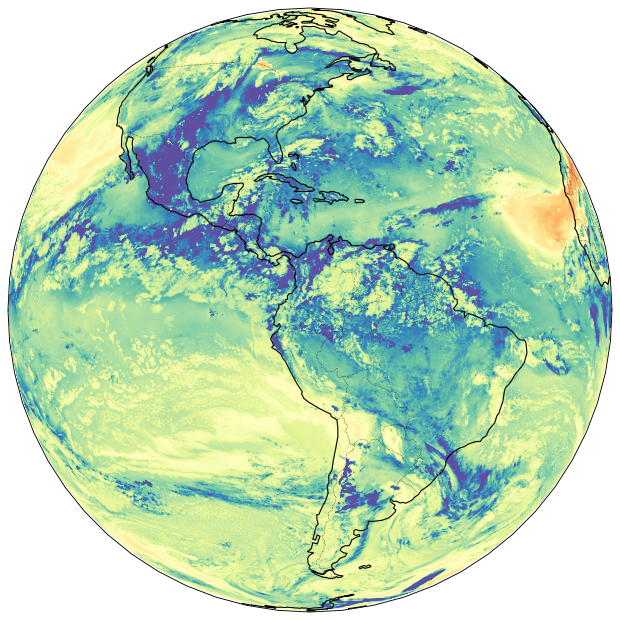

In [73]:
fig = plt.figure(figsize=(10,10))
ax  = plt.axes(projection=ccrs.Geostationary(central_longitude=lon_proj_origin,
                                             satellite_height=persp_height))

ax.coastlines()
ax.add_feature(BORDERS, edgecolor="k", lw=0.5,ls=":",zorder=10)

img = ax.imshow(data,vmin=vmin,vmax=vmax,cmap=colormap,origin="upper",extent=img_extent)

#fig.colorbar(img,label=legend,extend="both",orientation="horizontal")

In [74]:
#clear memory
del image1,image2,fig,ax,vmin,vmax,data

### Recrear ejemplo 2

---

In [61]:
#Air Mass RGB!
#Red:   diferencias entre bandas 6.2 y 7.3  -> diferencia entre bandas 8 y 10 del GOES
#       limitar esta banda a -26.2°C y 0.6°C de temperatura de brillo, esta nueva banda
#       se ha observado se un indicador de humedad en niveles altos
#Green: diferencias entre bandas 9.6 y 10.3 -> diferencia entre bandas 12 y 13 del GOES
#       limitar esta banda a -43.2°C y 6.7°C de temperatura de brillo, esta nueva banda
#       se ha observado se un indicador de la la altura de la tropopausa basado en el ozono
#Blue:  band 6.2 invertida?                 -> canal 8 dado vuelta, es decir 1-Blue
#       limitar esta banda a -29.25°C y -64.65°C de temperatura de brillo, esta nueva banda
#       se ha observado se un indicador de humedad en 500hPa -200hPa (niveles altos)
band1,band2,band3,band4 = "08","10","12","13"
img1,img2,img3,img4     = [xr.open_dataset(glob("data/OR_ABI-L2-CMIPF-M6C"+band+"_G16**.nc")[0],
                                           chunks="auto") for band in (band1,band2,band3,band4)]

#corregir las temperaturas de brillo a °C y achicar un poquito
data1,data2,data3,data4 = [im["CMI"][::4,::4]-273.15 for im in (img1,img2,img3,img4)]

#construir las bandas RGB correccion 1/gamma = 1
R = data1 - data2
G = data3 - data4
B = data1
 
#limites de temperatura de brillo
R = np.clip(R, -26.2, 0.6)
G = np.clip(G, -43.2, 6.7)
B = np.clip(B, -64.65, -29.25)
 
#correccion gamma y normalizar
R = ((R + 26.2) / (0.6 + 26.2)) ** (1/1)
G = ((G + 43.2) / (6.7 + 43.2)) ** (1/1)
B = ((B + 64.65) / (-29.25 + 64.65)) ** (1/1) 

#invertir la banda azul
B = 1.0 - B
#crear compuesto
RGB = np.stack([R, G, B], axis=2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


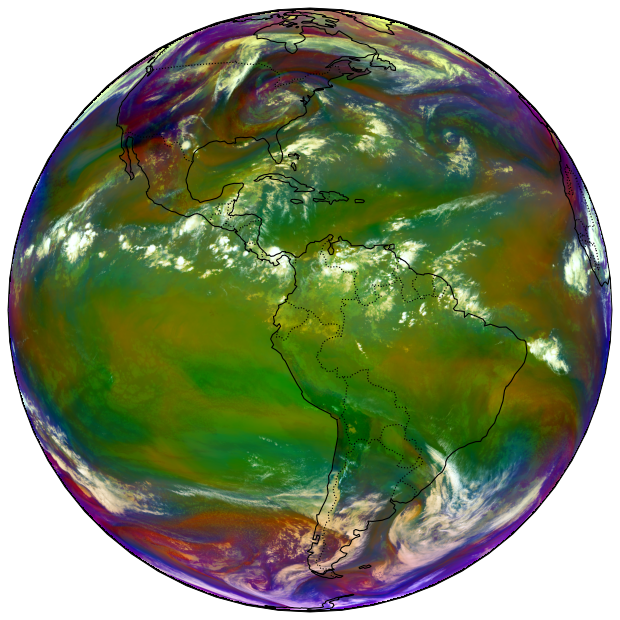

In [62]:
plt.figure(figsize=(10,10))
ax  = plt.axes(projection=ccrs.Geostationary(central_longitude=lon_proj_origin,
                                             satellite_height=persp_height))
ax.coastlines()
ax.add_feature(BORDERS,ls=":")

ax.imshow(RGB,origin="upper",extent=img_extent)

---

#### Ejemplo con una diferencia de bandas y un compuesto recreados/estudiados, ahora viene la resolucion de los ejercicios de la tarea

---

### Tarea2

---